# Multi-Stage Lithium-Ion Battery Aging Dataset - Basic Analyses

This notebook contains basic analyses of the Multi-Stage Lithium-Ion Battery Aging Dataset. The dataset is available at the [figshare Repository](https://doi.org/10.6084/m9.figshare.25975315).  
A detailed description of the dataset can be accessed in the [Dataset Descriptor](tbd..).

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import interpolate

import plotly.express as px
import plotly.graph_objects as go

from src.data_import import import_datafile
from src.feature_extraction import *

# Path to the dataset
base_path = Path("../data/Multi-Stage_Aging_Study_uncompressed/")
path_S1 = base_path / "Stage_1"
path_S2 = base_path / "Stage_2"


# RPT Analysis

## Data Import

The dataset is stored in a .csv file. The data is imported using the `import_datafile` function from the `src.data_import` module. The function returns a pandas DataFrame with the dataset.

In [2]:
# Select the dataset to be imported
stage = 1
aging_type = 'z'
tp = 8
cell = 1
RPT = 'ET_T23'

# Find the file
path = path_S1 if stage == 1 else path_S2
file = list(path.rglob(f"*_{aging_type}{tp:02d}_{cell:02d}_*_{RPT}.csv"))
print(f"Importing file: {file}")

# Import the data
df = import_datafile(file[0])

df.head()

Importing file: [PosixPath('../data/Multi-Stage_Aging_Study_uncompressed/Stage_1/TP_z08_01/TP_z08_01_01_ET_T23.csv')]


,run_time,c_vol,c_cur,c_surf_temp,amb_temp,step_type
0,0.000,4.075277,0.0,23.66179,0.000000,0
1,0.002,4.075277,0.0,23.66179,0.000000,0
2,10.000,4.075277,0.0,23.65875,22.979616,0
3,20.000,4.075277,0.0,23.66179,22.984318,0
4,30.000,4.075277,0.0,23.66179,23.023006,0


In [3]:
# Extract capacity

_capacity = capacity(df_capacity(df))
print(f"Mean Capacity: {_capacity['Q_mean']:.3f} Ah")
print(f"Charge Capacity: {_capacity['Q_ch']:.3f} Ah")
print(f"Discharge Capacity: {_capacity['Q_dch']:.3f} Ah")


Mean Capacity: 4.862 Ah
Charge Capacity: 4.857 Ah
Discharge Capacity: 4.867 Ah


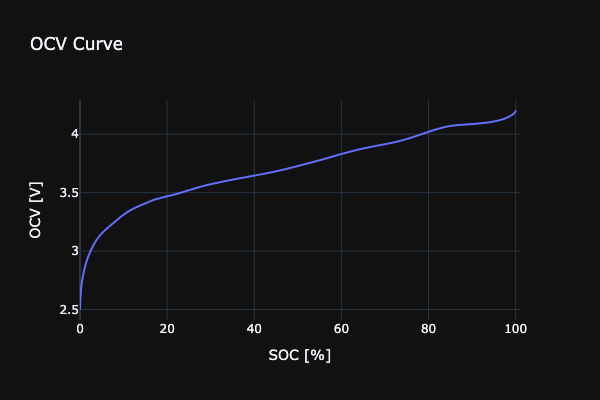

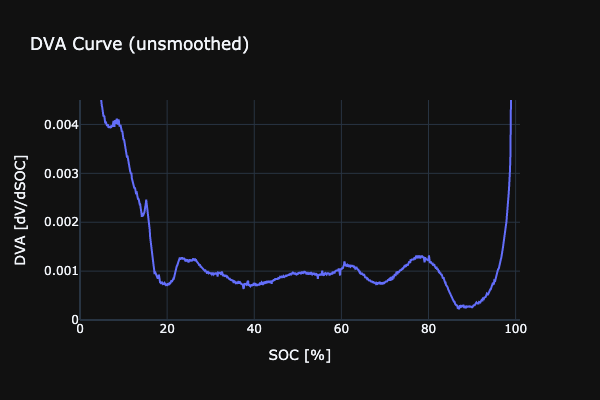

In [4]:
# Extract OCV

OCV = ocv_curve(df=df_ocv(df), enable_filter=False)
DVA_dch = dva_curve(ocv=OCV['OCV_dch'], soc=OCV['SOC'], enable_spline=False)

fig = px.line(x=OCV['SOC'], y=OCV['OCV'], title='OCV Curve').update_layout(width=600, height=400, xaxis=dict(range=[0, 101], title='SOC [%]'), yaxis=dict(title='OCV [V]'))
fig.show(renderer='png')

fig = px.line(x=OCV['SOC'][:-10], y=DVA_dch, title='DVA Curve (unsmoothed)').update_layout(width=600, height=400, xaxis=dict(range=[0, 101], title='SOC [%]'), yaxis=dict(range=[0, 0.0045], title='DVA [dV/dSOC]'))
fig.show(renderer='png')



In [5]:
# Extract DCIR (@ 50% SOC and -1C current pulse)

# Extract OCV functions for OCV correction
ocv_fcns = {'f_ocv(capacity)': interpolate.interp1d(OCV['SOC']*_capacity['Q_dch'],
                                                    OCV['OCV'],
                                                    kind='linear'),
            'f_capacity(ocv)': interpolate.interp1d(OCV['OCV'],
                                                    OCV['SOC']*_capacity['Q_dch'],
                                                    kind='linear')
            }

DCIR = rdc_extract(df=df_single_pulse(df, 5032), ocv_fcns=ocv_fcns, t=10)

print(f"DCIR(50% SOC, 1C discharge): {DCIR['RDC']*1000:.3f} mOhm")


DCIR(50% SOC, 1C discharge): 22.769 mOhm
